In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization
import cv2, warnings, random
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [3]:
train_dir = "../input/flower-classification/flowers/flowers/flower_photos/train/"
val_dir = "../input/flower-classification/flowers/flowers/flower_photos/validation/"
test_dir = "../input/flower-classification/flowers/flowers/flower_photos/test/"

In [4]:
def import_dataset(directory):
    images = []
    labels = []
    
    for category in os.listdir(directory):
        for file in os.listdir(directory+category):
            image_path = os.path.join(directory,category,file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image,(224,224))
            images.append(image)
            labels.append(category)
    
    images = np.array(images,dtype='float32')
    return images, labels

In [5]:
train_images, train_labels = import_dataset(train_dir)
valid_images, valid_labels = import_dataset(val_dir)
test_images, test_labels = import_dataset(test_dir)

In [6]:
train_images.shape, len(train_labels)

((3540, 224, 224, 3), 3540)

<AxesSubplot:ylabel='count'>

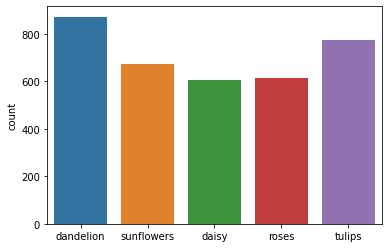

In [7]:
sns.countplot(train_labels)

<AxesSubplot:ylabel='count'>

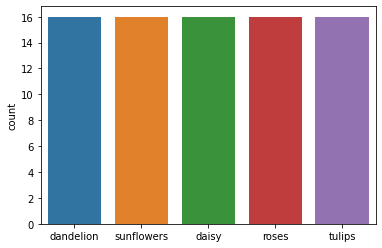

In [8]:
sns.countplot(valid_labels)

<AxesSubplot:ylabel='count'>

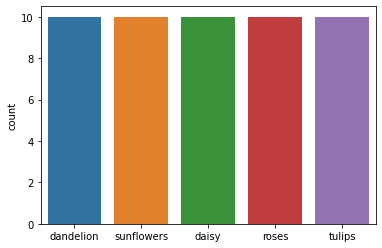

In [9]:
sns.countplot(test_labels)

In [10]:
def proportion(labels,dataset_type='train'):
    label_data = {'daisy': 0, 'roses': 1, 'dandelion': 2, 'sunflowers': 3, 'tulips': 4}
    plt.figure(figsize=(13,5))
    plt.title("Proportion of each Category in the {} dataset".format(dataset_type))
    plt.pie(x=pd.Series(labels).value_counts(), labels=list(label_data.keys()),  autopct='%.2f%%')
    plt.show()

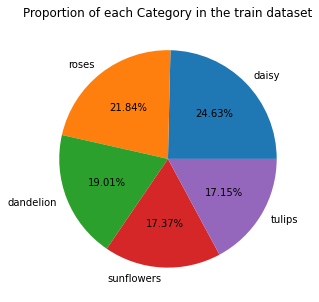

In [11]:
proportion(train_labels)

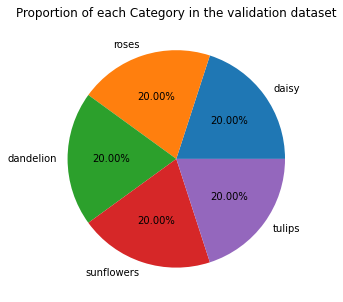

In [12]:
proportion(valid_labels,'validation')

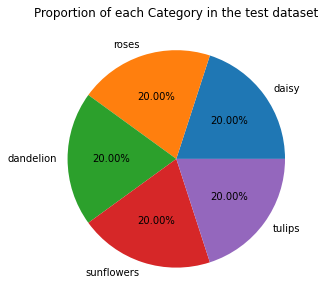

In [13]:
proportion(test_labels,'test')

In [14]:
train_images = train_images / 255.
valid_images = valid_images / 255.
test_images = test_images / 255.

In [15]:
encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_labels)
train_labels = to_categorical(train_labels)
valid_labels = encoder.transform(valid_labels)
valid_labels = to_categorical(valid_labels)
test_labels = encoder.transform(test_labels)
test_labels = to_categorical(test_labels)

In [16]:
# Initializing a CNN layer
cnn = Sequential()

# 1st Convolutional Layer
cnn.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
cnn.add(MaxPooling2D(pool_size=2,strides=2))
cnn.add(BatchNormalization())

# 2nd Convolutional Layer
cnn.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(BatchNormalization())

# 3rd Convolutional Layer
cnn.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

# 4th Convolutional Layer
cnn.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.3))

# Flatten
cnn.add(Flatten())

# Fully Connected Layer
cnn.add(Dense(units=128,activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

# Output Layer
cnn.add(Dense(units=5,activation='softmax'))

In [17]:
cnn.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')

In [18]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 111, 111, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 54, 54, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       7

In [22]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=20,mode='max',verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.1,patience=5,verbose=1,min_lr=0.001)
checkpoint_filepath = 'checkpoint/'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,monitor='val_accuracy',mode='max',save_best_only=True,verbose=1,save_weights_only=True)

r = cnn.fit(x=train_images,
            y=train_labels,
            epochs=30,
            batch_size=32,
            validation_data=(valid_images,valid_labels),
            callbacks=[early_stopping,reduce_lr,model_checkpoint])

Epoch 1/30
111/111 [==============================] - 142s 1s/step - loss: 0.3650 - accuracy: 0.8627 - val_loss: 0.8208 - val_accuracy: 0.7125

Epoch 00001: val_accuracy improved from -inf to 0.71250, saving model to checkpoint/
Epoch 2/30
111/111 [==============================] - 143s 1s/step - loss: 0.2775 - accuracy: 0.9006 - val_loss: 0.9344 - val_accuracy: 0.7500

Epoch 00002: val_accuracy improved from 0.71250 to 0.75000, saving model to checkpoint/
Epoch 3/30
111/111 [==============================] - 142s 1s/step - loss: 0.1900 - accuracy: 0.9347 - val_loss: 0.8556 - val_accuracy: 0.7750

Epoch 00003: val_accuracy improved from 0.75000 to 0.77500, saving model to checkpoint/
Epoch 4/30
111/111 [==============================] - 141s 1s/step - loss: 0.1614 - accuracy: 0.9438 - val_loss: 0.9963 - val_accuracy: 0.7125

Epoch 00004: val_accuracy did not improve from 0.77500
Epoch 5/30
111/111 [==============================] - 141s 1s/step - loss: 0.1578 - accuracy: 0.9475 - val_l

In [23]:
cnn.load_weights(checkpoint_filepath)

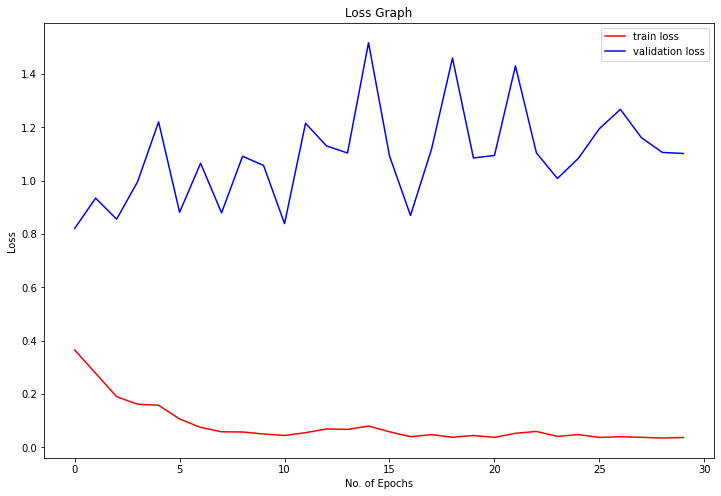

In [24]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

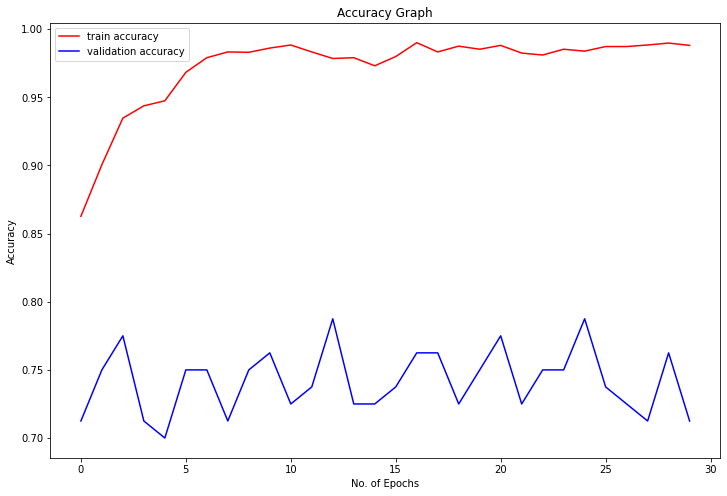

In [25]:
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='validation accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [74]:
test_pred = cnn.predict(test_images)

In [82]:
print("Accuracy Score:", str(int(np.sum(np.argmax(test_labels,axis=1) == np.argmax(test_pred,axis=1)) / len(test_labels) * 100)) + '%')

Accuracy Score: 64%


Original Label: daisy
Predicted Label: daisy


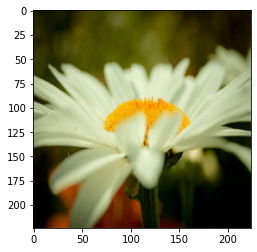

In [67]:
img_idx = random.randint(0,len(test_images))
print("Original Label:", encoder.inverse_transform([np.argmax(test_labels[img_idx])])[0])
pred = cnn.predict(test_images[img_idx].reshape(1,224,224,3))
predicted_label = encoder.inverse_transform([pred.argmax()])[0]
print("Predicted Label:", predicted_label)
plt.imshow(test_images[img_idx]);

Original Label: roses
Predicted Label: roses


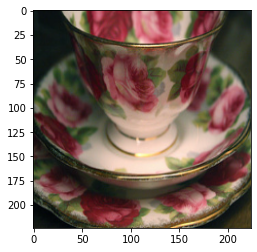

In [72]:
img_idx = 32
print("Original Label:", encoder.inverse_transform([np.argmax(test_labels[img_idx])])[0])
pred = cnn.predict(test_images[img_idx].reshape(1,224,224,3))
predicted_label = encoder.inverse_transform([pred.argmax()])[0]
print("Predicted Label:", predicted_label)
plt.imshow(test_images[img_idx]);